In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython import get_ipython
from IPython.display import display
from google.colab import drive
import pandas as pd
import json
from pandas import json_normalize
import uuid
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

# --- Set pandas display options ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [ ]:
# --- Function to create and cross check unique oid for each df ---
def generate_uuid():
    return str(uuid.uuid4())

# --- load and preprocess data ---
def load_data(filepath):
    with open(filepath, "r") as file:
        data = [json.loads(line) for line in file] #need to load it line by line since json.loads expects {{}{}..} as input but data is {}\n{}\n{}..

    # df_ = pd.DataFrame(data) #pd.DataFrame puts each key in column but also doesnt break up the json for that json_normalize is required
    df = json_normalize(data)
    df['uuid'] = df.apply(lambda _: generate_uuid(), axis=1)
    df.rename(columns={df.columns[df.columns.str.endswith("oid")][0]: 'oid'}, inplace=True)

    # check for any nested column in the df using isinstance of list or dict; df.dtypes considers the column object not list, so alternate methods
    nested_columns = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, (list, dict))).any()]
    print("nested column in df: \n", nested_columns)

    #alternatively one can check the data type of the first non na value of each column
    # checks how each column is defined this will catch it if there are any lists or dictionaries within any column
    display(df.apply(lambda col: type(col.dropna().iloc[0]) if not col.dropna().empty else None))


    # Rename columns with .$date prefix
    date_columns = []
    for col in df.columns:
        if col.endswith(".$date"):
          date_columns.append(col[:-6])
          df.rename(columns={col: col[:-6]}, inplace=True)  # Remove ".$date"

    # Convert date columns to datetime objects
    for col in date_columns:
        if col in df.columns:  # Check if column exists and is numeric
            df[col] = pd.to_datetime(df[col], unit='ms', errors='coerce')  # Assuming milliseconds
    return df

In [ ]:
receipts_df = load_data('/content/drive/MyDrive/receipts.json', ) # receipts does not normalize rewardsReceiptItemList since that column is defined as list
brands_df = load_data('/content/drive/MyDrive/brands.json')
users_df = load_data('/content/drive/MyDrive/users.json') # users normalizes cpg since cpg column is a dictionary

# receipts_df.info()
# brands_df.info()
# users_df.info()
#
# receipts_df[:3]
# users_df[:3]
# brands_df[:3]

nested column in df: 
 ['rewardsReceiptItemList']


,0
bonusPointsEarned,<class 'numpy.float64'>
bonusPointsEarnedReason,<class 'str'>
pointsEarned,<class 'str'>
purchasedItemCount,<class 'numpy.float64'>
rewardsReceiptItemList,<class 'list'>
rewardsReceiptStatus,<class 'str'>
totalSpent,<class 'str'>
userId,<class 'str'>
oid,<class 'str'>
createDate.$date,<class 'numpy.int64'>


nested column in df: 
 []


,0
barcode,<class 'str'>
category,<class 'str'>
categoryCode,<class 'str'>
name,<class 'str'>
topBrand,<class 'bool'>
oid,<class 'str'>
cpg.$id.$oid,<class 'str'>
cpg.$ref,<class 'str'>
brandCode,<class 'str'>
uuid,<class 'str'>


nested column in df: 
 []


,0
active,<class 'numpy.bool_'>
role,<class 'str'>
signUpSource,<class 'str'>
state,<class 'str'>
oid,<class 'str'>
createdDate.$date,<class 'numpy.int64'>
lastLogin.$date,<class 'numpy.float64'>
uuid,<class 'str'>


In [ ]:
_ = receipts_df[['oid','dateScanned','rewardsReceiptItemList']] # not changing the initial df to keep PK intact
# display(_.shape) #1119,2
# display(_[:3])

rewards_df_source = _.explode('rewardsReceiptItemList') #each item in rewardsReceiptItemList gets its own row but remains in dictionary form
display(rewards_df_source.shape) #7381,2
display(rewards_df_source[:3]) # this one has same indedx value for every row that was split into multiple rows

normalized_df = json_normalize(rewards_df_source['rewardsReceiptItemList'])
display(normalized_df.shape) #7381,34
display(normalized_df[:3]) # this one has diferent index values for each row, doesnt preserve oid

# Reset index of both DataFrames before concatenation
rewards_df = rewards_df_source.reset_index(drop=True)  # Reset index of rewards_df
normalized_df = normalized_df.reset_index(drop=True)  # Reset index of normalized_df

# the concatenation happens based on the index of the DataFrames. Since both rewards_df and normalized_df have been reset to have unique, sequential numeric indices (0, 1, 2, ...), pandas aligns them row-by-row during concatenation
receipt_items_df = pd.concat([rewards_df[['oid','dateScanned']], normalized_df], axis=1)
display(receipt_items_df.shape) #7381,35
receipt_items_df[:3]


(7381, 3)

,oid,dateScanned,rewardsReceiptItemList
0,5ff1e1eb0a720f0523000575,2021-01-03 15:25:31,"{'barcode': '4011', 'description': 'ITEM NOT F..."
1,5ff1e1bb0a720f052300056b,2021-01-03 15:24:43,"{'barcode': '4011', 'description': 'ITEM NOT F..."
1,5ff1e1bb0a720f052300056b,2021-01-03 15:24:43,"{'barcode': '028400642255', 'description': 'DO..."


(7381, 34)

,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,userFlaggedPrice,userFlaggedQuantity,needsFetchReviewReason,pointsNotAwardedReason,pointsPayerId,rewardsGroup,rewardsProductPartnerId,userFlaggedDescription,originalMetaBriteBarcode,originalMetaBriteDescription,brandCode,competitorRewardsGroup,discountedItemPrice,originalReceiptItemText,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId
0,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,26.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,True,1.0,028400642255,True,10.00,1.0,USER_FLAGGED,Action not allowed for user and CPG,5332f5fbe4b03c9a25efd0ba,DORITOS SPICY SWEET CHILI SINGLE SERVE,5332f5fbe4b03c9a25efd0ba,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(7381, 36)

,oid,dateScanned,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,userFlaggedPrice,userFlaggedQuantity,needsFetchReviewReason,pointsNotAwardedReason,pointsPayerId,rewardsGroup,rewardsProductPartnerId,userFlaggedDescription,originalMetaBriteBarcode,originalMetaBriteDescription,brandCode,competitorRewardsGroup,discountedItemPrice,originalReceiptItemText,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId
0,5ff1e1eb0a720f0523000575,2021-01-03 15:25:31,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,26.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ff1e1bb0a720f052300056b,2021-01-03 15:24:43,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ff1e1bb0a720f052300056b,2021-01-03 15:24:43,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,True,1.0,028400642255,True,10.00,1.0,USER_FLAGGED,Action not allowed for user and CPG,5332f5fbe4b03c9a25efd0ba,DORITOS SPICY SWEET CHILI SINGLE SERVE,5332f5fbe4b03c9a25efd0ba,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# display(receipts_df.columns)
# display(receipt_items_df.columns)

# receipts_df[:3]

# display(users_df['oid'].nunique())
# display(receipts_df['oid'].nunique())
# display(brands_df['oid'].nunique())
# display(receipt_items_df['oid'].nunique())

In [ ]:
def basic_eda(df, skip_columns=[]):

    print("*** Basic EDA ***")
    print(f"Total rows: {df.shape[0]}")
    print(f"Total columns: {df.shape[1]}")

    # print("\nData types and missing values:")
    # print(df.info())
    # print(df.describe())

    column_order = ['oid', 'uuid'] + [col for col in df.columns if col not in ['oid', 'uuid']]
    df = df[column_order]

    print("\nColumn Analysis:")
    for column in df.columns:
        if column in skip_columns:
            continue

        print(f"\n- {column}:")
        print(f"  Type: {df[column].dtype}")


        # Integer Columns
        if df[column].dtype == 'object':
            na_count = df[column].isna().sum()
            non_na_count = df[column].notna().sum()
            unique_count = df[column].nunique()
            print(f"  NA Count: {na_count}")
            print(f"  Non-NA Count: {non_na_count}")
            print(f"  Unique Values Count: {unique_count}")

        else:
            na_zero_count = df[(df[column] == 0) | (df[column].isna())].shape[0]
            non_na_non_zero_count = df[(df[column] != 0) & (df[column].notna())].shape[0]
            unique_count = df[column].nunique()
            print(f"  NA/Zero Count: {na_zero_count}")
            print(f"  Non-NA/Non-Zero Count: {non_na_non_zero_count}")
            print(f"  Unique Values Count: {unique_count}")

In [ ]:
numeric_cols = ['pointsEarned', 'bonusPointsEarned', 'purchasedItemCount', 'totalSpent']
basic_eda(receipts_df, ['rewardsReceiptItemList']) #skipping this column for receipts_df only since its a list
# basic_eda(users_df, [])
# basic_eda(brands_df, [])
# receipts_df[:4]

*** Basic EDA ***
Total rows: 1119
Total columns: 16

Column Analysis:

- oid:
  Type: object
  NA Count: 0
  Non-NA Count: 1119
  Unique Values Count: 1119

- uuid:
  Type: object
  NA Count: 0
  Non-NA Count: 1119
  Unique Values Count: 1119

- bonusPointsEarned:
  Type: float64
  NA/Zero Count: 575
  Non-NA/Non-Zero Count: 544
  Unique Values Count: 12

- bonusPointsEarnedReason:
  Type: object
  NA Count: 575
  Non-NA Count: 544
  Unique Values Count: 9

- pointsEarned:
  Type: object
  NA Count: 510
  Non-NA Count: 609
  Unique Values Count: 120

- purchasedItemCount:
  Type: float64
  NA/Zero Count: 499
  Non-NA/Non-Zero Count: 620
  Unique Values Count: 50

- rewardsReceiptStatus:
  Type: object
  NA Count: 0
  Non-NA Count: 1119
  Unique Values Count: 5

- totalSpent:
  Type: object
  NA Count: 435
  Non-NA Count: 684
  Unique Values Count: 94

- userId:
  Type: object
  NA Count: 0
  Non-NA Count: 1119
  Unique Values Count: 258

- createDate:
  Type: datetime64[ns]
  NA/Zero 

In [ ]:
def create_visualizations(df, skip_columns=[]):
    """
    Creates visualizations for the DataFrame.
    """
    skip_cols.extend([col for col in receipts_df.columns if re.search(r'.*id.*|.*Id.*', col)])  #adding any id columns
    print(skip_cols)
    print("\nVisualizations:")

    for column in df.columns:
            if column in skip_columns:
                continue

            plt.figure(figsize=(10, 6))

            if pd.api.types.is_numeric_dtype(df[column]):
                ax = sns.histplot(df[column], kde=True)
                plt.xlabel(column, fontsize=12)
                plt.ylabel("Frequency", fontsize=12)

            elif pd.api.types.is_datetime64_any_dtype(df[column]):
                ax = sns.histplot(df[column], kde=True)
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
                plt.xticks(rotation=45, ha='right')
                plt.xlabel(column, fontsize=12)
                plt.ylabel("Frequency", fontsize=12)

            elif df[column].dtype == 'object':
                sns.countplot(y=df[column], order=df[column].value_counts().index)
                plt.xlabel("Frequency", fontsize=12)
                plt.ylabel(column, fontsize=12)

            elif df[column].dtype == 'bool':
                sns.countplot(x=df[column])
                plt.xlabel(column, fontsize=12)
                plt.ylabel("Frequency", fontsize=12)

            plt.title(f"Distribution of {column}", fontsize=14)
            plt.tight_layout()
            plt.show()


['rewardsReceiptItemList', 'barcode', 'brandCode', 'name', 'cpg.$id.$oid', 'userId', 'oid', 'uuid']

Visualizations:


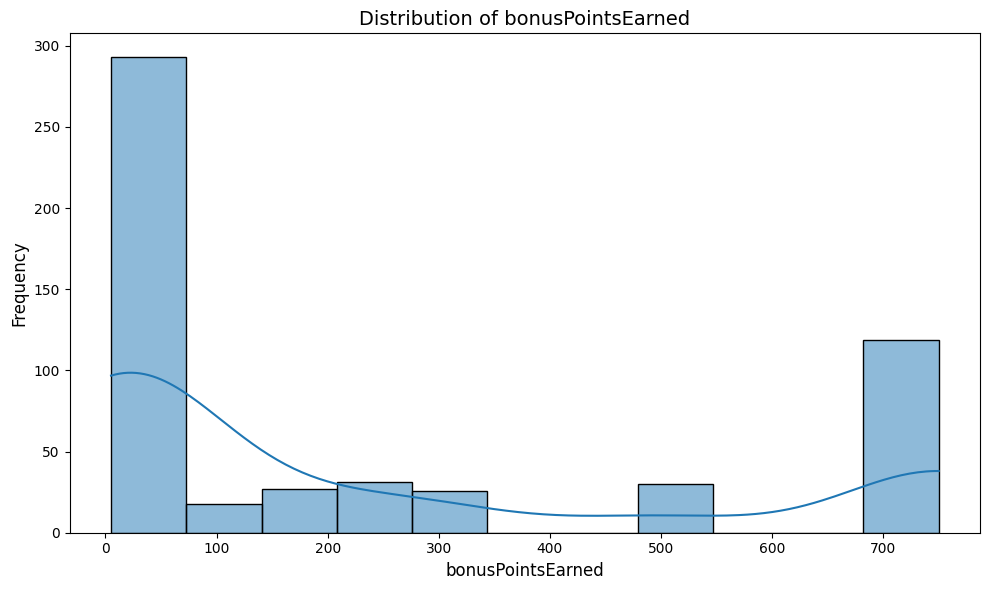

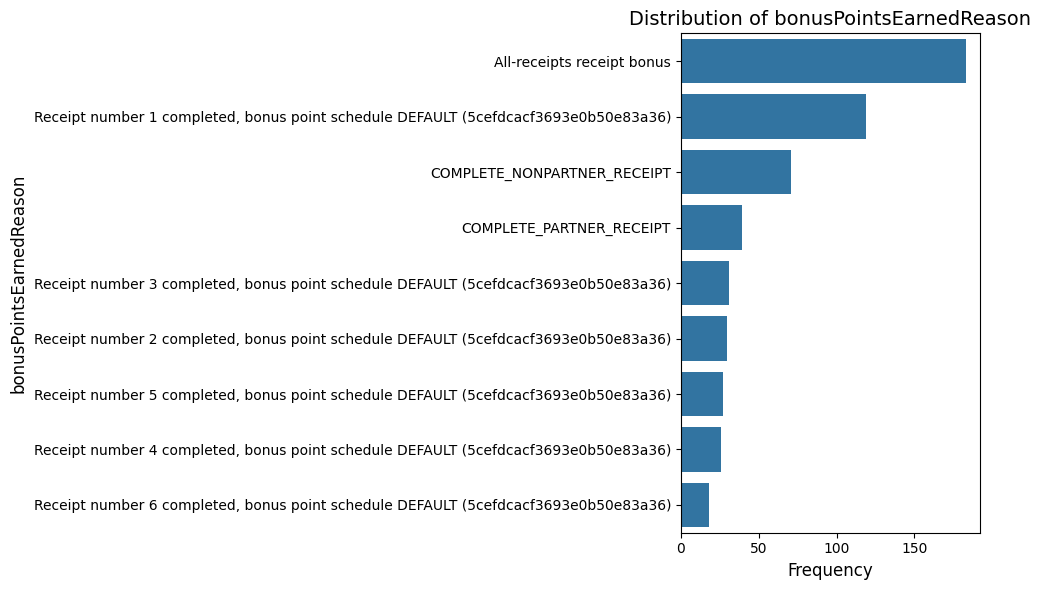

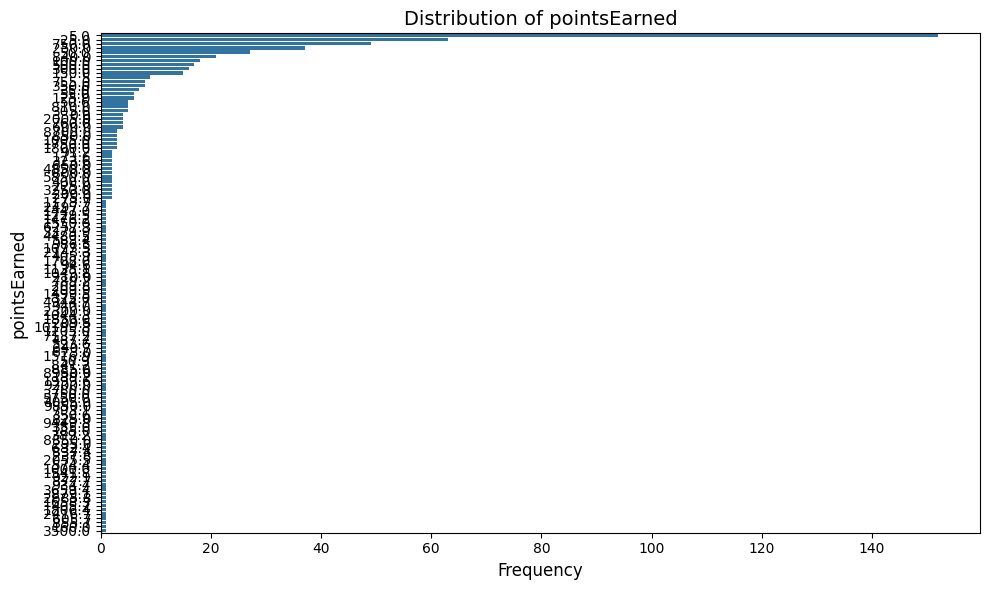

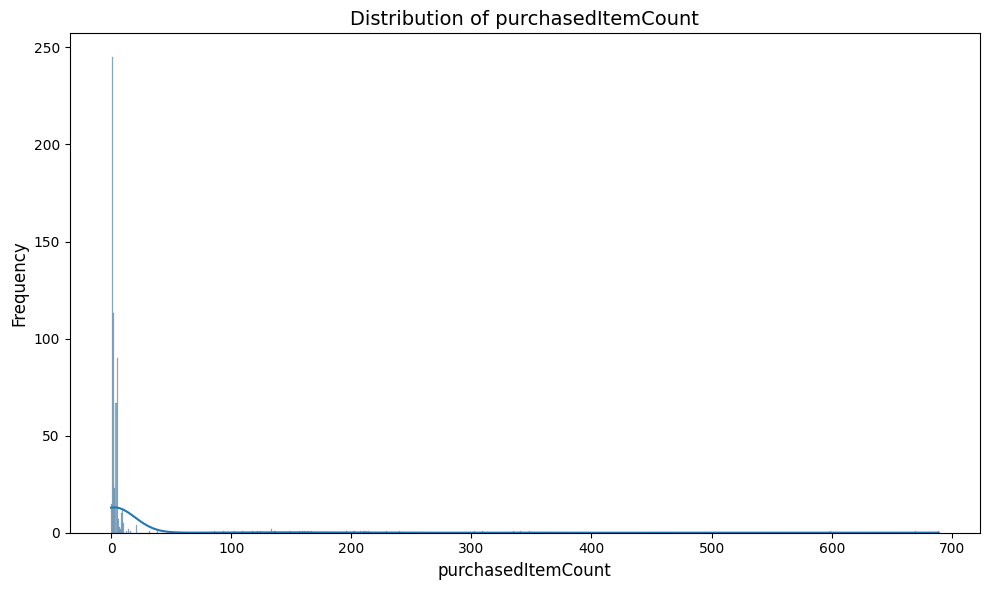

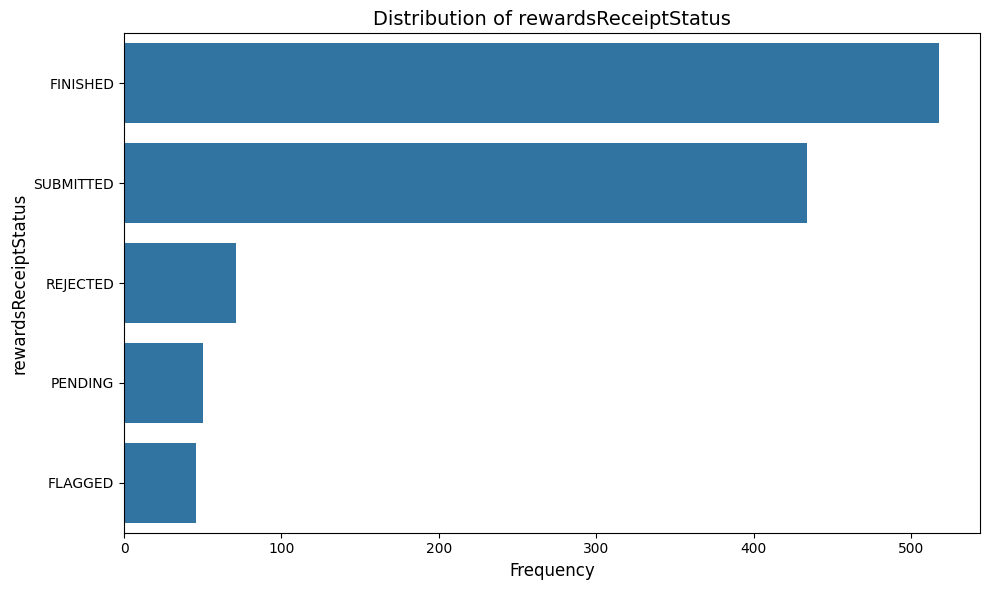

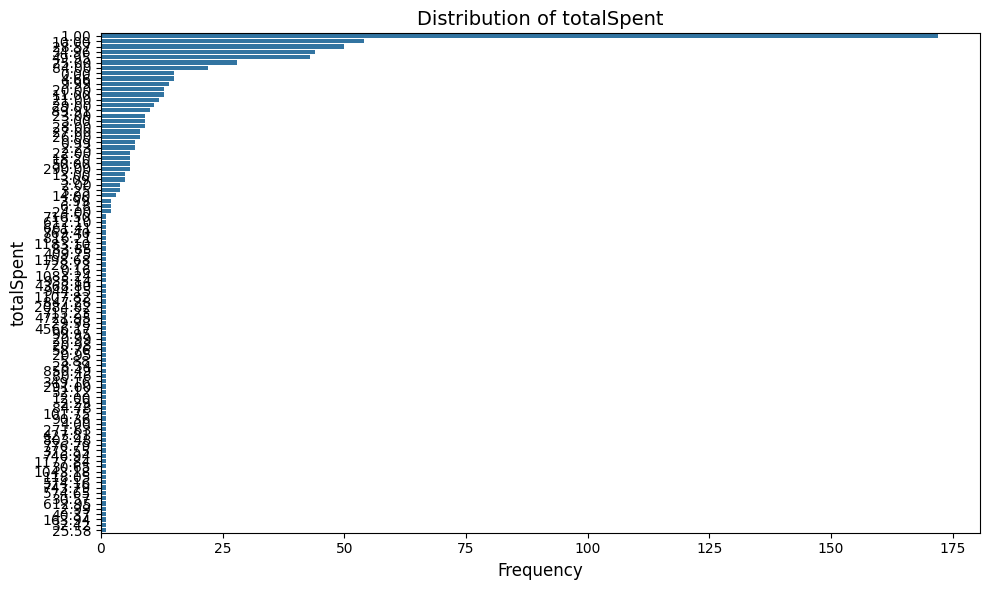

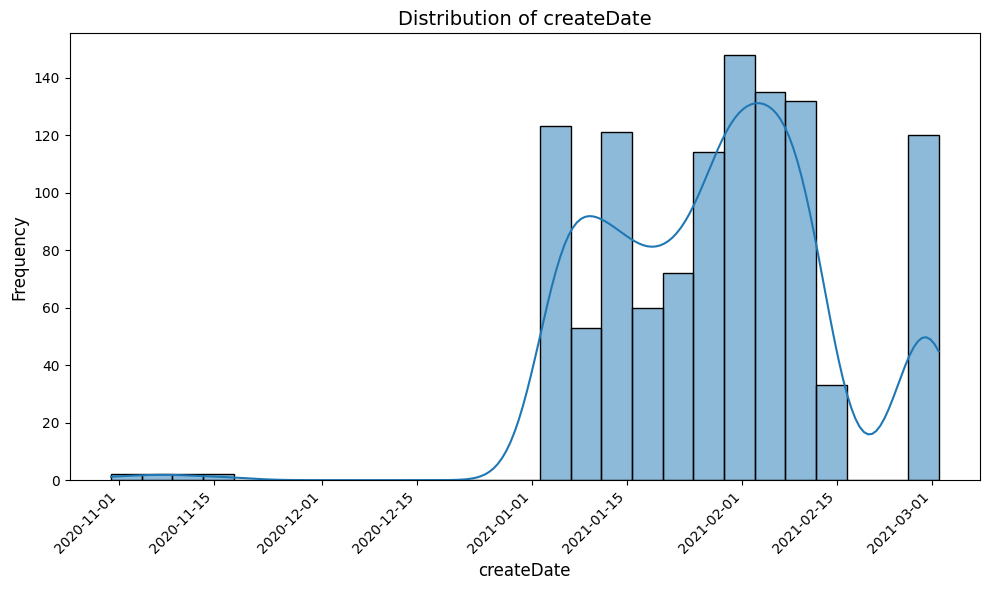

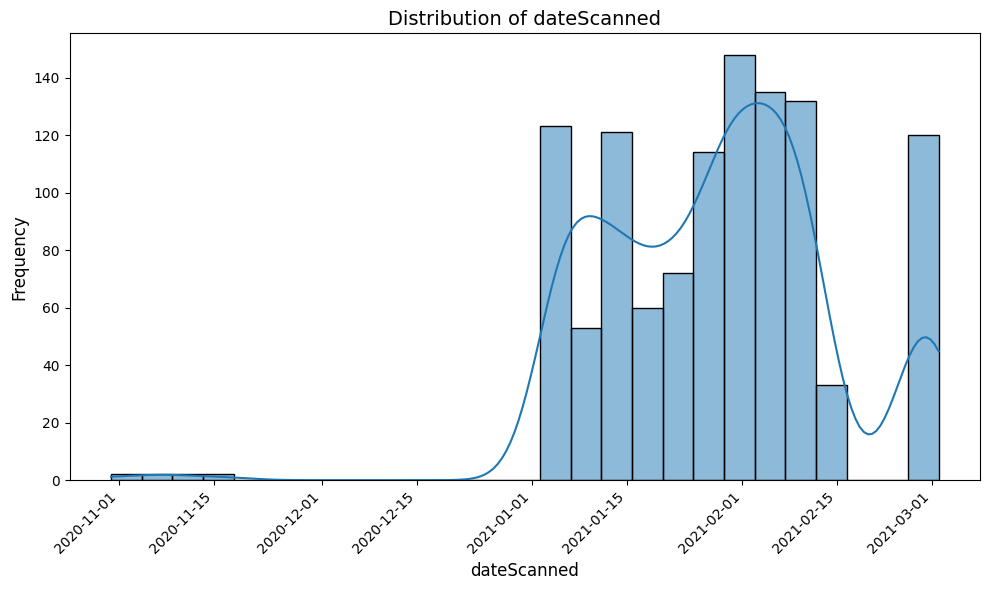

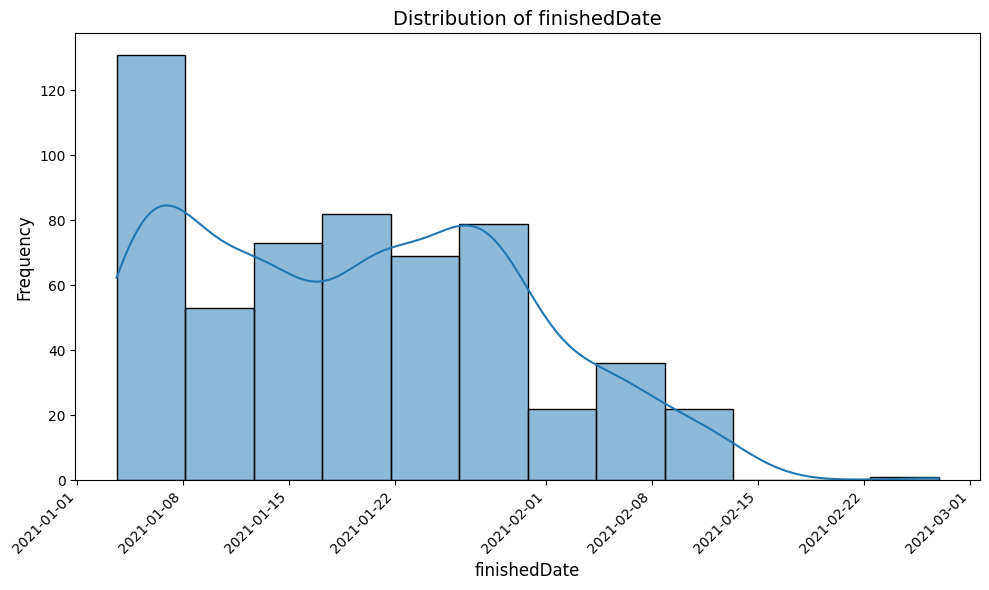

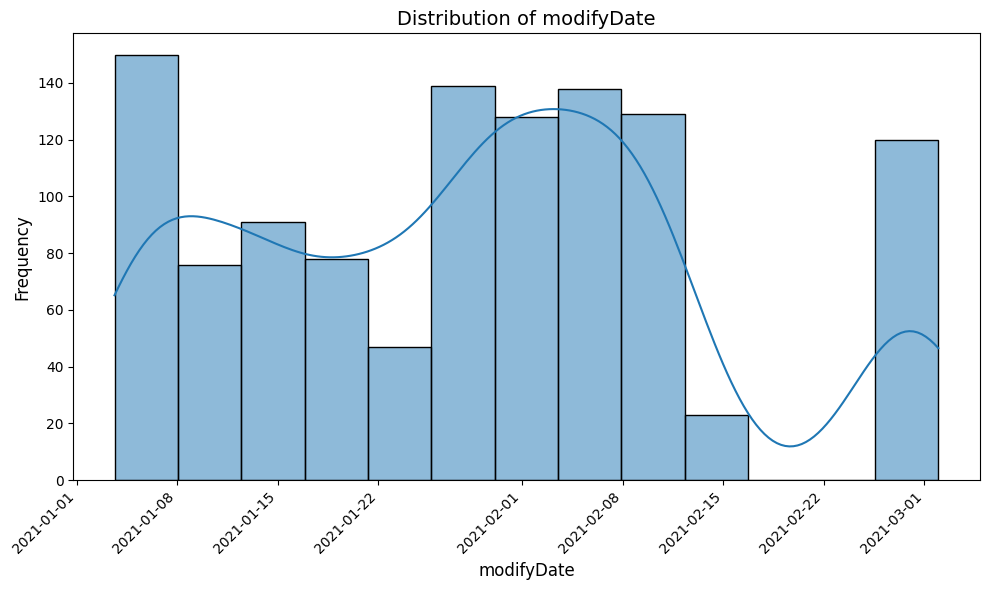

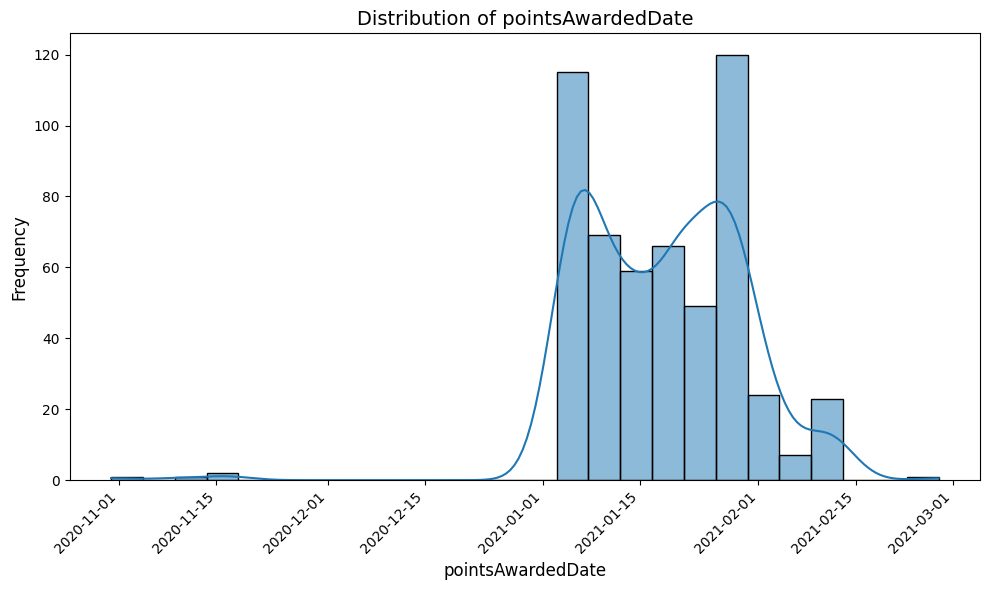

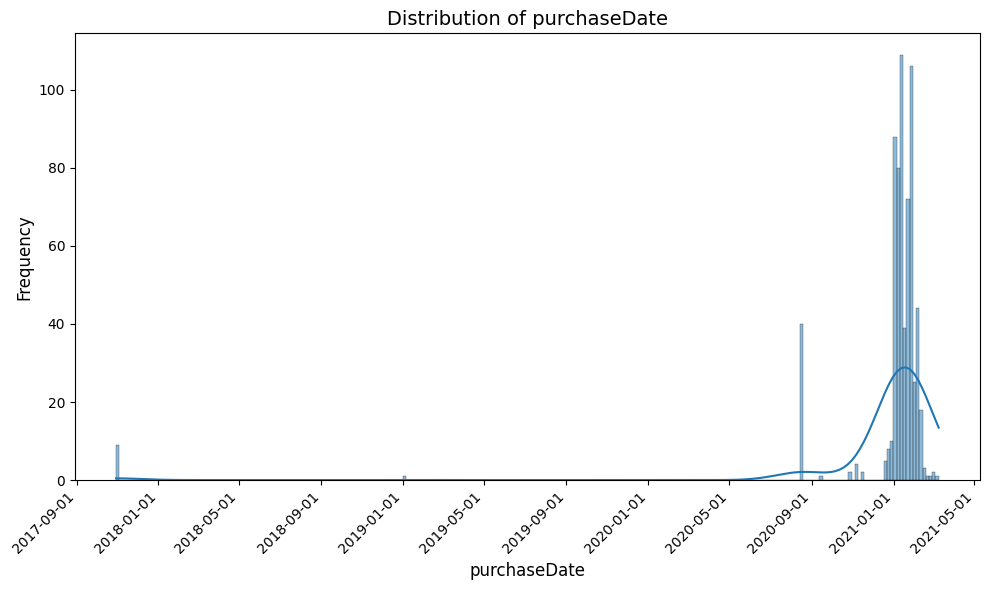

In [ ]:
skip_cols = ['rewardsReceiptItemList', 'barcode', 'brandCode', 'name', 'cpg.$id.$oid']

# uncomment for viewing each df
# create_visualizations(users_df, skip_cols)
create_visualizations(receipts_df, skip_cols)
# create_visualizations(brands_df, skip_cols)

# receipts data below this

In [ ]:
# Date comparison cases for reciept_df, are all dateScanned same as createDate, mostly yes except once
date_comparisons = [
    ('createDate', 'dateScanned'),
    ('dateScanned', 'finalizedDate'),
    ('finalizedDate', 'modifyDate'),
    ('modifyDate', 'purchaseDate')]

for date1, date2 in date_comparisons:
    print(date1, date2)
    # Check if both columns are present in the DataFrame
    if date1 in receipts_df.columns and date2 in receipts_df.columns:
        def check_dates(row):
            return pd.notna(row[date1]) and pd.notna(row[date2]) and row[date1] == row[date2]

        # Apply the custom function to each row and get a boolean Series
        date_match = receipts_df.apply(check_dates, axis=1)

        # Count True and False values
        true_count = date_match.sum()
        false_count = (~date_match).sum()  # ~ inverts the boolean Series

        # Print results
        print(f"\nCases where {date1} == {date2}:")
        print(f"  True count: {true_count}")
        print(f"  False count: {false_count}")

createDate dateScanned

Cases where createDate == dateScanned:
  True count: 1118
  False count: 1
dateScanned finalizedDate
finalizedDate modifyDate
modifyDate purchaseDate

Cases where modifyDate == purchaseDate:
  True count: 10
  False count: 1109


In [ ]:
# --- EDA for rewardsReceiptStatus and bonusPointsEarnedReason ---
print("\nCounts for rewardsReceiptStatus:")
counts_receipt_status = df['rewardsReceiptStatus'].value_counts(dropna=False)
print(counts_receipt_status)
print(f"Total count: {counts_receipt_status.sum()}")
print(f"NA count: {df['rewardsReceiptStatus'].isna().sum()}")

print("\nCounts for bonusPointsEarnedReason:")
counts_bonus_reason = df['bonusPointsEarnedReason'].value_counts(dropna=False)
print(counts_bonus_reason)
print(f"Total count: {counts_bonus_reason.sum()}")
print(f"NA count: {df['bonusPointsEarnedReason'].isna().sum()}")

# --- Cases where createDate != dateScanned ---
print("\nRow where createDate != dateScanned:")
display(df[df['createDate'].notna() & df['dateScanned'].notna() & (df['createDate'] != df['dateScanned'])])


Counts for rewardsReceiptStatus:
rewardsReceiptStatus
FINISHED     518
SUBMITTED    434
REJECTED      71
PENDING       50
FLAGGED       46
Name: count, dtype: int64
Total count: 1119
NA count: 0

Counts for bonusPointsEarnedReason:
bonusPointsEarnedReason
NaN                                                                                    575
All-receipts receipt bonus                                                             183
Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)    119
COMPLETE_NONPARTNER_RECEIPT                                                             71
COMPLETE_PARTNER_RECEIPT                                                                39
Receipt number 3 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     31
Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     30
Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)     27
Receipt number 

,oid,uuid,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,createDate,dateScanned,finalizedDate,modifyDate,pointsAwardedDate,purchaseDate
291,6000c74b0a7214ad4c000060,89190546-a126-4a7d-823d-6089bab8405c,0,NaN,0,0,NaN,SUBMITTED,0,5a43c08fe4b014fd6b6a0612,2021-01-14 22:35:53.595000029,2021-01-14 22:35:53.595999956,NaT,2021-01-14 22:35:53.595999956,NaT,NaT


In [ ]:
# are there cases when same user has different pruchase date, modify date etc how are the receipts getting modified do they get additional oid ?

duplicate_rows = receipts_df[receipts_df.duplicated(subset=['userId', 'purchaseDate'], keep=False)]
user_purchase_counts = receipts_df.groupby(['userId', 'purchaseDate'])['oid'].count().reset_index(name='count')

duplicate_user_purchases = user_purchase_counts[user_purchase_counts['count'] > 1]
# display(duplicate_user_purchases)

duplicate_info = []


for index, row in duplicate_user_purchases.iterrows():
    user_id = row['userId']
    purchase_date = row['purchaseDate']
    duplicate_count = row['count']


    filtered_df = receipts_df[(receipts_df['userId'] == user_id) & (receipts_df['purchaseDate'] == purchase_date)]
    modify_dates_statuses = filtered_df[['modifyDate', 'rewardsReceiptStatus']].values.tolist()
    duplicate_info.append([user_id, purchase_date, duplicate_count, modify_dates_statuses])

duplicate_df = pd.DataFrame(duplicate_info, columns=['userId', 'purchaseDate', 'duplicateCount', 'modifyDate_rewardsReceiptStatus'])
display(duplicate_df.head(3))

,userId,purchaseDate,duplicateCount,modifyDate_rewardsReceiptStatus
0,59c124bae4b0299e55b0f330,2021-01-12,20,"[[2021-01-12 22:03:42, PENDING], [2021-01-12 0..."
1,59c124bae4b0299e55b0f330,2021-02-05,28,"[[2021-02-05 17:10:24.650000, PENDING], [2021-..."
2,5c3388caea88e15513a95069,2021-01-04,2,"[[2021-01-04 16:25:19, FINISHED], [2021-01-04 ..."


In [ ]:
# Create a dictionary mapping user IDs to purchase dates
user_purchase_dates = {
    '5c3388caea88e15513a95069': pd.Timestamp('2021-01-04 00:00:00'),
    '5e27526d0bdb6a138c32b556': pd.Timestamp('2021-01-14 00:00:00'),
    '5fbc35711d967d1222cbfefc': pd.Timestamp('2020-12-30 00:00:00')
}


filtered_df = receipts_df[receipts_df.apply(lambda row: row['userId'] in user_purchase_dates and row['purchaseDate'] == user_purchase_dates[row['userId']], axis=1)]
filtered_df = filtered_df.sort_values(by=['userId', 'purchaseDate', 'createDate', 'dateScanned'])
display(filtered_df[:3])

,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,oid,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,purchaseDate,uuid
59,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,1.0,[{'description': 'flipbelt level terrain waist...,FINISHED,28.57,5c3388caea88e15513a95069,5ff3416d0a7214ada1000575,2021-01-04 16:25:17,2021-01-04 16:25:17,2021-01-04 16:25:17,2021-01-04 16:25:17,2021-01-04 16:25:17,2021-01-04,1a3af71c-f643-44bf-8c52-499ba41374e1
48,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,1.0,[{'description': 'flipbelt level terrain waist...,FINISHED,28.57,5c3388caea88e15513a95069,5ff3416f0a7214ada1000576,2021-01-04 16:25:19,2021-01-04 16:25:19,2021-01-04 16:25:19,2021-01-04 16:25:19,2021-01-04 16:25:19,2021-01-04,96399e13-4fef-4008-81ed-b77028a07919
279,150.0,"Receipt number 5 completed, bonus point schedu...",682.4,21.0,"[{'barcode': '076840100354', 'brandCode': 'BEN...",FINISHED,84.78,5e27526d0bdb6a138c32b556,6000b2be0a7214ad4c00004d,2021-01-14 21:08:14,2021-01-14 21:08:14,2021-01-14 21:08:22,2021-01-14 21:36:44,2021-01-14 21:08:22,2021-01-14,2feae278-dd1d-435b-ac83-0337a4a59c81


In [ ]:
# pointsEarned and bonusPointsEarned for each bonusPointsEarnedReason
result_df = receipts_df.groupby('bonusPointsEarnedReason', dropna=False)[['pointsEarned', 'bonusPointsEarned']].sum().reset_index()
result_df['bonusPointsEarnedReason'] = result_df['bonusPointsEarnedReason'].fillna('NA')

# counts for each reason
counts = receipts_df['bonusPointsEarnedReason'].value_counts(dropna=False)
counts.index = counts.index.fillna('NA')  # Replace NaN index with 'NA'
counts.name = 'count'  # Give the Series a name


result_df = result_df.merge(counts, on='bonusPointsEarnedReason', how='left')
display(result_df)

,bonusPointsEarnedReason,pointsEarned,bonusPointsEarned,count
0,All-receipts receipt bonus,55.05.05.05.05.05.05.05.05.055.05.0355.05.055....,915.0,183
1,COMPLETE_NONPARTNER_RECEIPT,35.025.025.025.035.025.025.025.025.025.025.025...,1775.0,71
2,COMPLETE_PARTNER_RECEIPT,185.050.050.0350.0100.050.050.050.050.050.050....,1618.0,39
3,"Receipt number 1 completed, bonus point schedu...",750.0750.0750.0750.0750.0750.01750.0750.0755.0...,89250.0,119
4,"Receipt number 2 completed, bonus point schedu...",500.0500.0500.0500.0500.09200.0500.0600.0600.0...,15000.0,30
5,"Receipt number 3 completed, bonus point schedu...",250.0250.03250.0250.01999.6350.0250.0250.0350....,7750.0,31
6,"Receipt number 4 completed, bonus point schedu...",300.0300.0389.2650.0300.0300.0825.0300.0300.03...,7800.0,26
7,"Receipt number 5 completed, bonus point schedu...",150.08850.0150.0275.0150.0275.0200.0150.0150.0...,4050.0,27
8,"Receipt number 6 completed, bonus point schedu...",100.0600.0225.0100.0225.0100.0189.2100.0100.01...,1800.0,18
9,NA,500.0250.0350.0250.0250.091.2250.0125.050.00.0...,0.0,575


In [ ]:
receipts_df['pointsEarned'] = pd.to_numeric(receipts_df['pointsEarned'], errors='coerce')

filtered_df = receipts_df[receipts_df['bonusPointsEarnedReason'].isna()]
total_points_earned = filtered_df['pointsEarned'].sum()
total_bonus_points_earned = filtered_df['bonusPointsEarned'].sum()
print(f"Total points earned: {total_points_earned}")
print(f"Total bonus points earned: {total_bonus_points_earned}")

receipts_df[:2]

Total points earned: 52486.799999999996
Total bonus points earned: 0.0


,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,oid,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,purchaseDate,uuid
0,500.0,"Receipt number 2 completed, bonus point schedu...",500.0,5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.00,5ff1e1eacfcf6c399c274ae6,5ff1e1eb0a720f0523000575,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,2021-01-03 00:00:00,bca45f0d-c21c-4d90-94fd-2299654f821a
1,150.0,"Receipt number 5 completed, bonus point schedu...",150.0,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.00,5ff1e194b6a9d73a3a9f1052,5ff1e1bb0a720f052300056b,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,2021-01-02 15:24:43,3e840a96-926f-423d-9ba3-9d50e7b3017d


In [ ]:

receipts_df['has_rewardsReceiptItemList'] = receipts_df['rewardsReceiptItemList'].apply(lambda x: isinstance(x, list) and len(x) > 0)

# Count rows without rewardsReceiptItemList
missing_count = receipts_df['rewardsReceiptItemList'].apply(lambda x: not isinstance(x, list) or len(x) == 0).sum()

print(f"Number of rows without rewardsReceiptItemList: {missing_count}")


Number of rows without rewardsReceiptItemList: 440


In [ ]:

filtered_df = receipts_df[receipts_df['rewardsReceiptItemList'].apply(lambda x: not isinstance(x, list) or len(x) == 0)]


zero_value_columns = ['bonusPointsEarned', 'pointsEarned']
na_check_columns = ['createDate', 'dateScanned', 'modifyDate', 'pointsAwardedDate', 'purchaseDate']

bonus_points_counts = filtered_df['bonusPointsEarned'].value_counts(dropna=False).sort_index()
print("Possible values and counts for 'bonusPointsEarned':")
print(bonus_points_counts)


points_earned_counts = filtered_df['pointsEarned'].value_counts(dropna=False).sort_index()
print("\nPossible values and counts for 'pointsEarned':")
print(points_earned_counts)

# Get NA and non-NA counts for other columns
for column in na_check_columns:
    na_count = filtered_df[column].isna().sum()
    not_na_count = filtered_df[column].notna().sum()
    print(f"{column}:")
    print(f"  NA count: {na_count}")
    print(f"  Non-NA count: {not_na_count}")

Possible values and counts for 'bonusPointsEarned':
bonusPointsEarned
250.0      1
500.0      1
NaN      438
Name: count, dtype: int64

Possible values and counts for 'pointsEarned':
pointsEarned
250.0      1
500.0      1
NaN      438
Name: count, dtype: int64
createDate:
  NA count: 0
  Non-NA count: 440
dateScanned:
  NA count: 0
  Non-NA count: 440
modifyDate:
  NA count: 0
  Non-NA count: 440
pointsAwardedDate:
  NA count: 438
  Non-NA count: 2
purchaseDate:
  NA count: 437
  Non-NA count: 3


In [ ]:
# Filter based on non-zero or non-NA values in specified columns
result_df = filtered_df[
    (filtered_df['bonusPointsEarned'] != 0) |
    (filtered_df['pointsEarned'] != 0) |
    filtered_df['pointsAwardedDate'].notna() |
    filtered_df['purchaseDate'].notna()
]


display(result_df[:4])

,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,oid,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,purchaseDate,uuid,has_rewardsReceiptItemList
71,NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5a43c08fe4b014fd6b6a0612,5ff475820a7214ada10005cf,2021-01-05 14:19:46,2021-01-05 14:19:46,NaT,2021-01-05 14:19:46,NaT,NaT,3730c8cf-7f40-4a66-9f43-714ba6e583c7,False
93,NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5a43c08fe4b014fd6b6a0612,5ff5ecb90a7214ada10005f9,2021-01-06 17:00:40,2021-01-06 17:00:40,NaT,2021-01-06 17:00:40,NaT,NaT,07b3ecd0-9551-4497-a64c-153e2775b233,False
149,NaN,NaN,NaN,NaN,NaN,SUBMITTED,NaN,5ff7264e8f142f11dd189504,5ff726860a720f05230005ec,2021-01-07 15:19:34,2021-01-07 15:19:34,NaT,2021-01-07 15:19:34,NaT,NaT,b41a0daf-6c9f-4bf0-b01b-416a6f9828ea,False
175,NaN,NaN,NaN,0.0,NaN,REJECTED,0.00,5ff8da28b3348b11c9337ac6,5ff8da570a720f05c5000015,2021-01-08 22:19:03,2021-01-08 22:19:03,NaT,2021-01-08 22:19:04,NaT,NaT,64d4b7d8-dc8a-441d-99b4-86de3ea015b9,False


In [ ]:
reward_items_df[:3]

,original_oid,_receiptId,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,userFlaggedPrice,userFlaggedQuantity,needsFetchReviewReason,pointsNotAwardedReason,pointsPayerId,rewardsGroup,rewardsProductPartnerId,userFlaggedDescription,originalMetaBriteBarcode,originalMetaBriteDescription,brandCode,competitorRewardsGroup,discountedItemPrice,originalReceiptItemText,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId
0,5ff1e1eb0a720f0523000575,5ff1e1eb0a720f0523000575,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,26.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ff1e1bb0a720f052300056b,5ff1e1bb0a720f052300056b,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ff1e1bb0a720f052300056b,5ff1e1bb0a720f052300056b,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,True,1.0,028400642255,True,10.00,1.0,USER_FLAGGED,Action not allowed for user and CPG,5332f5fbe4b03c9a25efd0ba,DORITOS SPICY SWEET CHILI SINGLE SERVE,5332f5fbe4b03c9a25efd0ba,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Filter for receipts with status 'FINISHED' or 'REJECTED'
filtered_receipts = receipts_df[receipts_df['rewardsReceiptStatus'].isin(['FINISHED', 'REJECTED'])]

# Get purchasedItemCount and rewardsReceiptStatus for each oid in the filtered receipts
purchased_item_counts = filtered_receipts[['oid', 'purchasedItemCount', 'rewardsReceiptStatus']]

# Get the list of oids from purchased_item_counts
oids_to_find = purchased_item_counts['oid'].tolist()

# Filter reward_items_df for matching oids and count occurrences
oid_counts_in_reward_items = reward_items_df[reward_items_df['original_oid'].isin(oids_to_find)]['original_oid'].value_counts().reset_index()
oid_counts_in_reward_items.columns = ['oid', 'count_in_reward_items']

merged_df = pd.merge(purchased_item_counts, oid_counts_in_reward_items, left_on='oid', right_on='oid', how='left')

merged_df['counts_match'] = merged_df['purchasedItemCount'] == merged_df['count_in_reward_items']

# Group by 'rewardsReceiptStatus' and count matches and non-matches
match_counts = merged_df.groupby('rewardsReceiptStatus')['counts_match'].agg(['sum', 'size']).reset_index()
match_counts.columns = ['rewardsReceiptStatus', 'match_count', 'total_count']
match_counts['non_match_count'] = match_counts['total_count'] - match_counts['match_count']


display(match_counts)
filtered_receipts_size = filtered_receipts.shape[0]
print(f"Size of filtered_receipts: {filtered_receipts_size}")

,rewardsReceiptStatus,match_count,total_count,non_match_count
0,FINISHED,381,518,137
1,REJECTED,59,71,12


Size of filtered_receipts: 589


In [ ]:
# Create sets of barcodes and brandCodes from brands_df
brands_barcodes = set(brands_df['barcode'].unique())
brands_brandCodes = set(brands_df['brandCode'].unique())

# Create new columns in reward_items_df indicating matches
reward_items_df['barcode_match'] = reward_items_df['barcode'].apply(lambda x: x in brands_barcodes)
reward_items_df['brandCode_match'] = reward_items_df['brandCode'].apply(lambda x: x in brands_brandCodes if pd.notna(x) else False)

# display(reward_items_df[:4])

# Count matches and mismatches for barcode
barcode_match_count = reward_items_df['barcode_match'].sum()
barcode_mismatch_count = (~reward_items_df['barcode_match']).sum()

# Count matches and mismatches for brandCode
brandCode_match_count = reward_items_df['brandCode_match'].sum()
brandCode_mismatch_count = (~reward_items_df['brandCode_match']).sum()

print("Barcode Matching:")
print(f"  Matches: {barcode_match_count}")
print(f"  Mismatches: {barcode_mismatch_count}")
print(f"  Total barcodes in reward_items_df: {reward_items_df['barcode'].nunique()}")
print(f"  Total barcodes in brands_df: {brands_df['barcode'].nunique()}")

print("\nBrandCode Matching:")
print(f"  Matches: {brandCode_match_count}")
print(f"  Mismatches: {brandCode_mismatch_count}")
print(f"  Total brandCodes in reward_items_df: {reward_items_df['brandCode'].nunique()}")
print(f"  Total brandCodes in brands_df: {brands_df['brandCode'].nunique()}")

Barcode Matching:
  Matches: 82
  Mismatches: 6859
  Total barcodes in reward_items_df: 568
  Total barcodes in brands_df: 1160

BrandCode Matching:
  Matches: 629
  Mismatches: 6312
  Total brandCodes in reward_items_df: 227
  Total brandCodes in brands_df: 897


# Brands data below this


In [ ]:
grouped_brands = brands_df.groupby(['barcode', 'name', 'categoryCode','category','brandCode'], dropna=False).size().reset_index(name='count')

display(grouped_brands[:4])
grouped_brands.shape

,barcode,name,categoryCode,category,brandCode,count
0,511111000167,Third Shift Brewing,NaN,Beer Wine Spirits,THIRD SHIFT,1
1,511111000235,Saint Archer,NaN,Beer Wine Spirits,SAINT ARCHER,1
2,511111000396,Coors Extra Gold,NaN,Beer Wine Spirits,COORS EXTRA GOLD,1
3,511111000440,AUNT JEMIMA Dry Breakfast Mixes,NaN,Breakfast & Cereal,AUNT JEMIMA DRY BREAKFAST MIXES,1


(1167, 6)

In [ ]:
duplicate_rows = brands_df[brands_df.duplicated(subset=['name'], keep=False)]
duplicate_rows = duplicate_rows.sort_values(by=['name'])
# display(duplicate_rows)
brands_df['name'].nunique()

1156

In [ ]:
brand_counts = brands_df.groupby('name').size().reset_index(name='count')

brand_counts = brand_counts.sort_values(by=['count'], ascending=False)
total_count = brand_counts['count'].sum()
# display(brand_counts)
print(f"Total sum of counts: {total_count}")

Total sum of counts: 1167


duplicate_rows = brands_df[brands_df.duplicated(subset=['barcode'], keep=False)]
duplicate_rows = duplicate_rows.sort_values(by=['barcode'])
display(duplicate_rows)

In [ ]:
duplicate_rows.barcode.nunique()

22

In [ ]:
duplicate_rows = brands_df[brands_df.duplicated(subset=['name'], keep=False)]
duplicate_rows = duplicate_rows.sort_values(by=['name'])
# display(duplicate_rows)
# duplicate_rows.shape

In [ ]:
brands_df.columns

Index(['barcode', 'category', 'categoryCode', 'name', 'topBrand', 'oid',
       'cpg.$id.$oid', 'cpg.$ref', 'brandCode', 'uuid', 'cpg'],
      dtype='object')

In [ ]:
cpg_oid_counts = brands_df.groupby('cpg.$id.$oid').size().reset_index(name='count')
cpg_ref_counts = brands_df.groupby('cpg.$ref').size().reset_index(name='count')

total_counts_cpg_oid = cpg_oid_counts['count'].sum()
print(cpg_oid_counts.sum())

total_counts_Ref = cpg_ref_counts['count'].sum()
print(cpg_ref_counts.sum())

cpg.$id.$oid    5332f5ebe4b03c9a25efd0a85332f5f2e4b03c9a25efd0...
count                                                        1167
dtype: object
cpg.$ref    CogsCpgs
count           1167
dtype: object


# User data below this

In [ ]:
users_df[users_df['active'] == False]

,active,role,signUpSource,state,oid,createdDate,lastLogin,uuid,diff_days_created_lastLogin,diff_days_lastLogin_today,lastLogin_year
240,False,consumer,Email,WI,6008622ebe5fc9247bab4eb9,2021-01-20 17:02:38.662,2021-01-20 17:02:38.931,ee017f91-5b42-4cf8-991f-887b29b1d4fc,0.0,1505.0,2021.0


In [ ]:
# Convert 'createdDate' and 'lastLogin' to datetime objects if they are not already
users_df['createdDate'] = pd.to_datetime(users_df['createdDate'].apply(lambda x: x['$date'] if isinstance(x, dict) else x), unit='ms', errors='coerce')
users_df['lastLogin'] = pd.to_datetime(users_df['lastLogin'].apply(lambda x: x['$date'] if isinstance(x, dict) else x), unit='ms', errors='coerce')


users_df['diff_days_created_lastLogin'] = (users_df['lastLogin'] - users_df['createdDate']).dt.days
users_df['diff_days_lastLogin_today'] = (pd.Timestamp(datetime.now()) - users_df['lastLogin']).dt.days

diff_counts_created_lastLogin = users_df.groupby('diff_days_created_lastLogin')['oid'].count().reset_index(name='count')
diff_counts_lastLogin_today = users_df.groupby('diff_days_lastLogin_today')['oid'].count().reset_index(name='count')


print("Difference between createdDate and lastLogin:")
print(diff_counts_created_lastLogin)

print("\nDifference between lastLogin and today:")
print(diff_counts_lastLogin_today.head(10))

Difference between createdDate and lastLogin:
   diff_days_created_lastLogin  count
0                          0.0    342
1                         85.0     20
2                         94.0      3
3                        119.0     19
4                        190.0      1
5                       1116.0      1
6                       1143.0      8
7                       1238.0     18
8                       1332.0      1
9                       2268.0     20

Difference between lastLogin and today:
   diff_days_lastLogin_today  count
0                     1461.0     20
1                     1462.0     20
2                     1468.0     20
3                     1469.0      3
4                     1482.0     10
5                     1483.0      5
6                     1484.0      1
7                     1485.0      3
8                     1486.0     20
9                     1490.0      6


In [ ]:
users_df['lastLogin_year'] = users_df['lastLogin'].dt.year
most_common_year = users_df['lastLogin_year'].mode()[0]
most_common_year

2021.0

In [ ]:
# EDA on rewardsReceiptItemList column

# changes happen through iterrows, but I went with explode and normalize functions to make it cleaner

# json_normalize doesnt handle flattening of rewardsReceiptItemList since its a list
	# •	It works well when a column contains a dictionary (key-value pairs become columns).
	# •	If a column contains a list, json_normalize treats it as a single object (keeps it as is)
# row 2 has multiple dictionaries, comma seperated in rewardsReceiptItemList, check below
# receipts_df['rewardsReceiptItemList'].str.len()
# nan_count = receipts_df['rewardsReceiptItemList'].isna().sum()
# non_nan_count = receipts_df['rewardsReceiptItemList'].str.len().sum()
# nan_count+non_nan_count --> 440 entires do not have a rewardsReceiptItemList, total 7381 entries
# row 71, 93 etc have empty rewardsReceiptItemList check below
# receipts_df[receipts_df['rewardsReceiptItemList'].isna()].loc[:, ['oid', 'rewardsReceiptItemList']][:5]
# need a function that can handle both sceanrios with NA and multiple dictionaries --> df.explode handles both cases
# _ = receipts_df[['oid', 'rewardsReceiptItemList']][71:72]; _ = receipts_df[['oid', 'rewardsReceiptItemList']][:2]
# _.explode(['rewardsReceiptItemList'])
# # _

# def load_rewardsItemList(df):
#     reward_items_data = []
#     for index, row in df.iterrows():
#         # Check if rewardsReceiptItemList is valid and not empty
#         if isinstance(row['rewardsReceiptItemList'], list) and row['rewardsReceiptItemList']:
#             for item in row['rewardsReceiptItemList']:
#                 item['row_oid'] = row['oid']  # Add row_oid to each item
#                 reward_items_data.append(item)
#         else:
#             # Handle empty or invalid rewardsReceiptItemList
#             reward_items_data.append({'row_oid': row['oid']})  # Append empty dictionary with row_oid

#     reward_items_df = pd.json_normalize(reward_items_data)
#     return reward_items_df  # Return the DataFrame

# rewards_df = receipts_df[['oid', 'rewardsReceiptItemList']] # not changing the initial df to keep PK intact
# # display(rewards_df.shape) #1119,2
# rewards_df = load_rewardsItemList(rewards_df)
# # rewards_df.shape (7381, 35)

In [ ]:
# QUESTION 1 SQL

# checking how many receipt_items_df have datescanned in 2021-03, pulled in dateScanned into receipt_items_df
march_2021_receipts = receipt_items_df[
    (receipt_items_df['dateScanned'].dt.year == 2021) &
    (receipt_items_df['dateScanned'].dt.month == 3)
]
# march_2021_receipts.head()


receipts_with_brandCode = receipt_items_df[~(receipt_items_df['brandCode'].isna())]
print(f"Number of receipts with brandCode: {len(receipts_with_brandCode)}")
receipts_with_brandCode.head()

filtered_df = receipt_items_df[
    (receipt_items_df['dateScanned'].dt.year == 2021) &
    (receipt_items_df['dateScanned'].dt.month == 3)
]
print(f"Receipts in March 2021: {filtered_df.shape[0]}")
# Then filter the filtered_df again
filtered_df = filtered_df[~(filtered_df['brandCode'].isna())]
print(f"Receipts with Brandcode in March 2021: {filtered_df.shape[0]}")


# Perform inner join on 'oid'
merged_receipts = pd.merge(march_2021_receipts, receipts_with_brandCode, on='oid', how='inner')

# Display the merged DataFrame
print(f"Number of receipts matching both conditions: {len(merged_receipts)}")
merged_receipts.head()


Number of receipts with brandCode: 2600
Receipts in March 2021: 43
Receipts with Brandcode in March 2021: 0
Number of receipts matching both conditions: 0


,oid,dateScanned_x,barcode_x,description_x,finalPrice_x,itemPrice_x,needsFetchReview_x,partnerItemId_x,preventTargetGapPoints_x,quantityPurchased_x,userFlaggedBarcode_x,userFlaggedNewItem_x,userFlaggedPrice_x,userFlaggedQuantity_x,needsFetchReviewReason_x,pointsNotAwardedReason_x,pointsPayerId_x,rewardsGroup_x,rewardsProductPartnerId_x,userFlaggedDescription_x,originalMetaBriteBarcode_x,originalMetaBriteDescription_x,brandCode_x,competitorRewardsGroup_x,discountedItemPrice_x,originalReceiptItemText_x,itemNumber_x,originalMetaBriteQuantityPurchased_x,pointsEarned_x,targetPrice_x,competitiveProduct_x,originalFinalPrice_x,originalMetaBriteItemPrice_x,deleted_x,priceAfterCoupon_x,metabriteCampaignId_x,dateScanned_y,barcode_y,description_y,finalPrice_y,itemPrice_y,needsFetchReview_y,partnerItemId_y,preventTargetGapPoints_y,quantityPurchased_y,userFlaggedBarcode_y,userFlaggedNewItem_y,userFlaggedPrice_y,userFlaggedQuantity_y,needsFetchReviewReason_y,pointsNotAwardedReason_y,pointsPayerId_y,rewardsGroup_y,rewardsProductPartnerId_y,userFlaggedDescription_y,originalMetaBriteBarcode_y,originalMetaBriteDescription_y,brandCode_y,competitorRewardsGroup_y,discountedItemPrice_y,originalReceiptItemText_y,itemNumber_y,originalMetaBriteQuantityPurchased_y,pointsEarned_y,targetPrice_y,competitiveProduct_y,originalFinalPrice_y,originalMetaBriteItemPrice_y,deleted_y,priceAfterCoupon_y,metabriteCampaignId_y


In [ ]:
# Can one receipt have multiple brandCodes -- yes

# brand_count_per_oid = receipt_items_df.groupby('oid')['brandCode'].nunique().reset_index(name='brandCode_count')
# brand_count_per_oid = brand_count_per_oid.sort_values(by=['brandCode_count'], ascending=False)  # Add this line
# print(brand_count_per_oid)

# lets look at sample receipts such that oid have muliptle brandcode

oids_to_show = ['6000b2be0a7214ad4c00004d', '6008f09d0a720f05fa000128']
receipt_items_df[receipt_items_df['oid'].isin(oids_to_show)][['oid', 'dateScanned', 'brandCode', 'barcode', 'description']]


,oid,dateScanned,brandCode,barcode,description
637,6000b2be0a7214ad4c00004d,2021-01-14 21:08:14,BEN AND JERRYS,076840100354,BEN & JERRYS FROZEN CHUNKY MONKEY ICE CREAM RE...
638,6000b2be0a7214ad4c00004d,2021-01-14 21:08:14,NaN,NaN,KLARBRUNN 12PK 12 FL OZ
639,6000b2be0a7214ad4c00004d,2021-01-14 21:08:14,KLEENEX,036000391718,KLEENEX POP UP RECTANGLE BOX FACIAL TISSUE 2 P...
640,6000b2be0a7214ad4c00004d,2021-01-14 21:08:14,BORDEN,NaN,"BORDEN 2% MILK, 1/2 GAL"
641,6000b2be0a7214ad4c00004d,2021-01-14 21:08:14,NaN,NaN,EMIL' S SAUSAGE MUSHROOM PIZZA
642,6000b2be0a7214ad4c00004d,2021-01-14 21:08:14,KLEENEX,036000391718,KLEENEX POP UP RECTANGLE BOX FACIAL TISSUE 2 P...
643,6000b2be0a7214ad4c00004d,2021-01-14 21:08:14,BEN AND JERRYS,311111511867,BEN AND JERRYS ICE CREAM
644,6000b2be0a7214ad4c00004d,2021-01-14 21:08:14,BEN AND JERRYS,076840100354,BEN & JERRYS FROZEN CHUNKY MONKEY ICE CREAM RE...
2809,6008f09d0a720f05fa000128,2021-01-21 03:10:21,BORDEN,815473013279,Borden 2% Reduced Fat Milk
2810,6008f09d0a720f05fa000128,2021-01-21 03:10:21,BEN AND JERRYS,076840100354,BEN & JERRYS FROZEN CHUNKY MONKEY ICE CREAM RE...


In [ ]:
# SQL query 3 eda

# can one receipt have multiple rewardsReceiptStatus -- no
# can one receipt NA rewardsReceiptStatus --lets see -- no
display(receipts_df.shape)
display(receipts_df.rewardsReceiptStatus.value_counts())
display(receipts_df.rewardsReceiptStatus.value_counts().sum()) #--matches the size of df
display(receipts_df.rewardsReceiptStatus.isna().sum())

In [ ]:
# are there sceanrios that status changes between different oid -- no, if it does there is a new oid for it

# # Group by 'oid' and get unique 'rewardsReceiptStatus' values for each group
# receipt_status_transitions = receipts_df.groupby('oid')['rewardsReceiptStatus'].nunique().reset_index(name='unique_status_count')

# # Filter for receipts with more than one unique status
# transitioning_receipts = receipt_status_transitions[receipt_status_transitions['unique_status_count'] > 1]

# # # Display the transitioning receipts
# display(transitioning_receipts)

# # # Count the number of transitioning receipts
# transitioning_receipts.shape[0]



,oid,unique_status_count


0

In [ ]:
# SQL query 4 eda

# can one receipt have multiple rewardsReceiptStatus -- no
# can one receipt NA rewardsReceiptStatus --lets see -- no
display(receipts_df.shape)
display(receipts_df.purchasedItemCount.value_counts())
# display(receipts_df.purchasedItemCount.value_counts().sum())
display(receipts_df.purchasedItemCount.isna().sum()) #--sum of na and non-na matches the size of df
# display(receipts_df[receipts_df.purchasedItemCount.isna()].head()) #-- cases when purchasedItemCount is na
# receipts_df[(receipts_df.purchasedItemCount.isna()) & (~receipts_df.	totalSpent.isna())][['dateScanned','rewardsReceiptItemList']] #-- cases when purchasedItemCount is na but totalSpent is not! FLAGGED rows

(1119, 16)

,count
purchasedItemCount,
1.0,245
2.0,113
5.0,90
4.0,67
3.0,23
0.0,15
10.0,12
9.0,10
6.0,7


484

In [ ]:
# sql query 5 eda
# -- how to identify how many users are there with create date greator than 2020-09
# display(users_df.createdDate.value_counts().sort_index())
# users_df[users_df.createdDate >= '2020-09-01']['createdDate'].value_counts().sort_index().sum()

# -- there are multiple entires with the same oid in the users_df, there are only 212 unique oids in usersdf out of 495 entries
#lets look at some of the ids which are not unique
# users_df[users_df.oid.isin(['5ffcb4bc04929111f6e92608', '5fff4beedf9ace121f0c17ea', '6009e60450b3311194385009'])]

# -- used this to see entries with dates greator than 2020-09 and see verified the corresponding createDate, since there are more than one, aggregated it by max, can as well use min
# filtered = users_df[users_df['createdDate'] > '2020-09-01'].groupby('oid')[['createdDate']].max()
filtered.shape #-- 205 users have create date higher than 2020-09
# what is the max createDate in usersdf?
# users_df['createdDate'].max()

# Group by 'oid' and get the number of unique 'createDate' values for each group --verfied that createDate is same
# users_df.groupby('oid')['lastLogin'].nunique().reset_index(name='lastLogin_count').sort_values(by='lastLogin_count', ascending=False)
# users_df.groupby('oid')['lastLogin'].size().reset_index(name='lastLogin_count').sort_values(by='lastLogin_count', ascending=False)
# users_df[users_df.oid.isin(['54943462e4b07e684157a532', '5ff47392c3d63511e2a47881'])]
